# Pairs Trading Strategy

The objective of the project is to implement pairs trading strategy on a portfolio of US stocks. Engle Granger procedure is used to select the pairs and the trading strategy is developed based on the strength of cointegration.

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.api import adfuller
from statsmodels.api import OLS
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('seaborn-v0_8-notebook')

In [6]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)

## 1. Selecting the list of US Stocks

Below file contains the list of stocks traded in NASDAQ.

In [7]:
nasdaq_stocks = pd.read_csv('nasdaq stocks.csv')

We consider stocks with market cap between 10 Million to 1 Billion USD.

In [8]:
reference_stocks = nasdaq_stocks[(nasdaq_stocks['Market Cap']<1e12) & (nasdaq_stocks['Market Cap']>10e9)]
len(reference_stocks)

788

## 2. Extracting the data from Yahoo Finance

The stock data is taken for the last 10 years from ```'2012-01-01'``` to ```'2022-01-01'```.

In [79]:
stock_data = yf.download(reference_stocks['Symbol'].to_list(),start = '2012-01-01',end ='2022-01-01')

[***************       32%%                      ]  252 of 788 completed

Failed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)


[**********************89%%*****************     ]  702 of 788 completed

Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  788 of 788 completed


16 Failed downloads:
['TPG', 'ARM', 'VLTO', 'SATX', 'ASBA', 'HLN', 'GEHC', 'BKDT', 'CEG', 'CRBG', 'KVUE', 'VFS', 'AGNCL', 'BAM']: Exception("%ticker%: Data doesn't exist for startDate = 1325394000, endDate = 1641013200")
['BRK/B', 'BRK/A']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [26]:
stock_data.index = pd.to_datetime(stock_data.index)

Removing Stocks which were not available since last 10 years.

In [27]:
stock_prices = stock_data['Adj Close'].dropna(axis=1)
len(stock_prices.columns)

614

In [28]:
normalized_prices = stock_prices/stock_prices.iloc[0,:]

In [29]:
normalization_ratio = stock_prices.iloc[0,:]

## 3. Testing for Cointegration between the selected stocks

### 3.1 Implementing Regression between each pair

In [30]:
def pair_wise_reg(Y,X):
    X = X.values
    X = np.hstack([np.ones(X.shape[0]).reshape(-1,1),X.reshape(-1,1)])
    Y = Y.values.reshape(-1,1)
    model = OLS(Y,X).fit()
    return {'alpha':model.params[0],'beta':model.params[1],'t-stat':model.tvalues[1],
            'p-value':model.pvalues[1],'r-sq':model.rsquared}

In [139]:
reg_df = pd.DataFrame()
for i in range(normalized_prices.shape[1]-1):
    for j in range(i+1,normalized_prices.shape[1]):
        Y = normalized_prices.iloc[:,i]
        X = normalized_prices.iloc[:,j]
        reg_output = pair_wise_reg(Y,X)
        if abs(reg_output['beta']) < 1:
            Y,X = X.copy(),Y.copy()
            reg_output = pair_wise_reg(Y,X)
        reg_output = {'Y':normalized_prices.iloc[:,i].name,'X':normalized_prices.iloc[:,j].name,**reg_output}
        if reg_df.empty:
            reg_df = pd.DataFrame(reg_output,index=[0])
        else:
            reg_df = pd.concat([reg_df,pd.DataFrame(reg_output,index=[0])],ignore_index=True)
    if i%100 == 0:
        print(f'{i/normalized_prices.shape[1]*100:.2f}% completed...')

0.00% completed...
16.37% completed...
32.73% completed...
49.10% completed...
65.47% completed...
81.83% completed...
98.20% completed...


In [31]:
#reg_df.to_csv('Regression Output.csv')
reg_df = pd.read_csv('Regression Output.csv',index_col=0)

Removing pairs with p-value greater than 0.05 or beta < 1.

In [32]:
reg_df = reg_df[(reg_df['p-value']<0.05)&(reg_df['beta']>1)]

### 3.2 Implementing ADF test to test the stationarity

In [22]:
adf_p_val = []

for i in range(len(reg_df)):
    Y,X,alpha,beta = reg_df.iloc[i][['Y','X','alpha','beta']]
    residuals = normalized_prices[Y] - alpha - beta *normalized_prices[X]
    adf_p_val.append(adfuller(residuals,maxlag=1)[1])
    if i%10000 == 0:
        print(f'{i/reg_df.shape[0]*100:.2f}% completed...')

reg_df['ADF p-value'] = adf_p_val

0.00% completed...
8.37% completed...
16.74% completed...
25.11% completed...
33.47% completed...
41.84% completed...
50.21% completed...
58.58% completed...
66.95% completed...
75.32% completed...
83.69% completed...
92.05% completed...


In [33]:
#reg_df.to_csv('ADF Results.csv')
adf_result = pd.read_csv('ADF Results.csv',index_col=0)

Removing results which are not stationary

In [34]:
adf_result = adf_result[adf_result['ADF p-value']<0.05]

### 3.3 Testing the predictive power of the residual using ECM

In [35]:
def ECM(Y,X,alpha,beta):
    del_Y = Y.diff().dropna().values
    del_X = X.diff().dropna().values
    residuals = (Y - alpha - beta * X).shift(1).dropna().values
    model = OLS(del_Y.reshape(-1,1),np.hstack([del_X.reshape(-1,1),residuals.reshape(-1,1)])).fit()
    return model.params[1],model.pvalues[1],model.rsquared


In [26]:
coint_strength_vals = []
coint_strength_pvalue_vals = []
coint_strength_rsq_vals = []
for i in range(len(adf_result)):
    Y_val,X_val,alpha,beta = adf_result.iloc[i][['Y','X','alpha','beta']]
    Y = normalized_prices[Y_val]
    X = normalized_prices[X_val]
    strength,pvalue,rsq = ECM(Y,X,alpha,beta)
    coint_strength_vals.append(strength)
    coint_strength_pvalue_vals.append(pvalue)
    coint_strength_rsq_vals.append(rsq)
    if i%1000 ==0:
        print(f'{i/len(adf_result)*100:.2f}% completed...')
        
adf_result['Coint Strength'] = coint_strength_vals
adf_result['Coint Strength p-value'] = coint_strength_pvalue_vals
adf_result['Coint Strength Rsq'] = coint_strength_rsq_vals

0.00% completed...
7.53% completed...
15.07% completed...
22.60% completed...
30.14% completed...
37.67% completed...
45.20% completed...
52.74% completed...
60.27% completed...
67.81% completed...
75.34% completed...
82.88% completed...
90.41% completed...
97.94% completed...


In [36]:
#adf_result.to_csv('ECM Results.csv')
ECM_result = pd.read_csv('ECM Results.csv',index_col=0)

Filtering out pairs that don't have significant predictive power.

In [37]:
ECM_result = ECM_result[(ECM_result['Coint Strength p-value']<0.05)&(ECM_result['ADF p-value']<0.05)]
len(ECM_result)

9887

## 4. Fitting the spread to an OU process

### 4.1 Ornstein-Uhlenbeck Process:

From the previous sections, the spread between the cointegrating pairs was found to be stationary. Since the spread is stationary, it is considered to follow a mean reverting process which is called Ornstein-Uhlenbeck (OU) Process. The OU process has the following dynamics:

$$dr_t = \theta(\mu - r_t)dt +\sigma dX_t$$ where $\theta$ is the speed of reversion

The SDE is solved below:

$$\begin{align*}
dr &= \theta(\mu - r)dt +\sigma dX\\
\\
e^{\theta t}dr & = e^{\theta t}(\theta (\mu - r)dt + \sigma dX) \qquad \qquad \quad \quad\text{(Multiplying by $e^{\theta t}$)}\\
\\
e^{\theta t}dr &= \mu  \theta e^{\theta t} dt -  r \theta e^{\theta t} dt + e^{\theta t} \sigma dX\\
\\
e^{\theta t}dr +r \theta e^{\theta t} dt &= \mu  \theta e^{\theta t} dt   + e^{\theta t} \sigma dX\\
\\
d(re^{\theta t}) &= \mu  \theta e^{\theta t}  dt   + e^{\theta t} \sigma dX  \qquad \qquad \qquad \quad \text{(Applying Ito's Lemma)}\\
\\
\int_t^T d(r_s e^{\theta s}) &=  \mu \theta \int_t^T e^{\theta s} ds + \sigma \int_t^T e^{\theta s} dX_s  \qquad \text{(Integrating from t to T)}\\
r_{T} e^{\theta T} - r_t e^{\theta t} &= \mu (e^{\theta T} - e^{\theta t}) + \sigma \int_t^T e^{\theta s} dX_s\\
\end{align*}$$

$$\begin{equation*}
\boxed{r_{T} = r_t e^{-\theta (T-t)} + \mu (1- e^{-\theta (T-t)}) + \sigma e^{-\theta T} \int_t^T e^{\theta s} dX_s} \tag{1}
\end{equation*}$$

The above equation is the solution for the mean reverting process $r_T$ given the information at time $t$. Below equations give the expectation and variance of $r_T.$

$$\begin{align*} 
\mathbb{E}[r_{T}|\mathcal{F}_t] &= \mathbb{E}_t \bigl [r_t e^{-\theta (T-t)} + \mu (1- e^{-\theta (T-t)}) + \sigma e^{-\theta T} \int_t^T e^{\theta s} dX_s\bigr]\\
&= r_t e^{-\theta (T-t)}+ \mu (1- e^{-\theta (T-t)}) + \sigma e^{-\theta T} \mathbb{E}_s \bigl[  \int_t^T e^{\theta s} dX_s\bigr]\\
\\
&= r_t e^{-\theta (T-t)}+ \mu (1- e^{-\theta (
T-t)})\qquad\small\text{(Expection of an Ito Integral is zero)}\tag{2}\\
\\
\\
Var[r_T|\mathcal{F}_t] &= Var\bigl(r_t e^{-\theta (T-t)} + \mu (1- e^{-\theta (T-t)}) + \sigma e^{-\theta T} \int_t^T e^{\theta s} dX_s\bigr)\\
&=Var\bigl(\sigma e^{-\theta T} \int_t^T e^{\theta s} dX_s\bigr)\\ &= \sigma^2 e^{-2 \theta T} Var\bigl(\int_t^T e^{\theta s} dX_s\bigr)\\
&=\sigma^2 e^{-2 \theta T} \mathbb{E}\bigl[\int_t^T e^{2\theta s}dt\bigr] \qquad \qquad \small \text{(Ito Isometry)}\\
&=\sigma^2 e^{-2 \theta T}\biggl(\frac{e^{2 \theta T - 2 \theta t}}{2\theta}\biggr)\\
&=\frac{\sigma^2}{2\theta}\bigl(1-e^{-2\theta(T-t)}\bigr)\tag{3}
\end{align*}$$

From the above equations for mean and variance, the long term equilibrium mean $\mu_{eq}$ and variance $\sigma^2_{eq}$ can be found. 

As $T \gt \gt t, (T-t)\to \infty$. Applying this to equations (2) and (3) gives 

$$ \begin{equation*}
\boxed{\mu_{eq}= \mu} \tag{4}\\
\end{equation*}$$
$$\begin{equation*}
\boxed{\sigma^2_{eq} = \frac{\sigma^2}{2\theta}} \tag{5}
\end{equation*}$$

### 4.2 Fitting the signal to the OU process

To fit the cointegrating residuals to the OU process, the following AR(1) model is created.

$$ r_t = a + br_{t-1} + \epsilon_t \tag{6}$$

The long term mean can be derived from (6) as $$\begin{equation*}\boxed{\mu_{eq} = \frac{a}{1-b}}\end{equation*}\tag{7}$$

The speed of reversion can be derived from (6) as $$\begin{equation*}\boxed{\theta = -\frac{ln(b)}{(T-t)}}\end{equation*}\tag{8}$$

The long term variance can be derived from (6) as $$\begin{equation*}\boxed{\sigma^2_{eq} = \frac{Var(\epsilon)}{1-e^{-2\theta(T-t)}}}\end{equation*}\tag{9}$$

Since the model is bulit on daily prices, $$(T-t) = \frac{1}{252}$$

In [38]:
def OU_fit(Z):
    Z_1 = np.hstack([np.ones(Z.shape[0]-1).reshape(-1,1),Z.shift(1).dropna().values.reshape(-1,1)])
    Z = Z.values[1:]
    model = OLS(Z,Z_1).fit()
    a,b = model.params
    theta_sig,OU_rsq = model.pvalues[1],model.rsquared
    mean_eq = a/(1-b)
    theta = -np.log(b)*252
    var_eq = np.var(model.resid)/(1-np.exp(-2*theta/252))
    return {'Mean_Eq':mean_eq,'Theta':theta,'Theta p-value':theta_sig,'OU R-sq':OU_rsq,'Var_Eq':var_eq}

In [71]:
OU_result_df = pd.DataFrame()
for i in range(len(ECM_result)):
    Y_val,X_val,alpha,beta = ECM_result.iloc[i][['Y','X','alpha','beta']]
    Y = normalized_prices[Y_val]
    X = normalized_prices[X_val]
    Z = Y - beta * X
    OU_fit_result = OU_fit(Z)
    if OU_result_df.empty:
        OU_result_df = pd.DataFrame(OU_fit_result,index=[0])
    else:
        OU_result_df = pd.concat([OU_result_df,pd.DataFrame(OU_fit_result,index=[0])],ignore_index=True)
OU_fit_result = pd.concat([ECM_result.reset_index(),OU_result_df],axis=1,)

In [39]:
#OU_fit_result.to_csv('OU Results.csv')
OU_fit_result = pd.read_csv('OU Results.csv',index_col=0).drop('index',axis=1)

In [40]:
hedge_ratio = []
for i in range(OU_fit_result.shape[0]):
    hedge_ratio.append(stock_prices[OU_fit_result.iloc[i]['Y']].iloc[0]/stock_prices[OU_fit_result.iloc[i]['X']].iloc[0]*OU_fit_result.iloc[i]['beta'])

In [41]:
OU_fit_result['hedge_ratio'] = hedge_ratio

Filtering out rows to focus on the most significant pairs

In [248]:
p_value_threshold = 0.01
r_sq_threshold = 0.2

In [249]:
final_pairs_df =  OU_fit_result[(OU_fit_result['p-value']<p_value_threshold)&
                  (OU_fit_result['Coint Strength p-value']<p_value_threshold)&
                  (OU_fit_result['ADF p-value']<p_value_threshold)&
                  (OU_fit_result['Theta p-value']<p_value_threshold)&
                  (OU_fit_result['Coint Strength Rsq']>r_sq_threshold)&
                    (OU_fit_result['hedge_ratio']>1)]

In [250]:
len(final_pairs_df)

669

## 5. Trading Strategy and Backtesting

### 5.1 Strategy

In [209]:
class pairs_trading_strategy():
    def __init__(self,
                 prices_df,
                 n_positions = 10,
                 init_cash_amt = 100000,
                 margin = 0.2,
                 long_entry_threshold=1.5,
                 long_exit_threshold=2.5,
                 short_entry_threshold=-1.5,
                 short_exit_threshold=-2.5):

        self.final_pairs = final_pairs_df.sort_values('Theta',ascending=False)
        self.final_pairs['Pair ID'] = np.arange(self.final_pairs.shape[0])
        self.prices_df = prices_df
        self.prices_df.index = pd.to_datetime(self.prices_df.index)
        self.adj_close = prices_df['Adj Close']
        self.normalized_prices = self.adj_close/ normalization_ratio
        self.price_adjustment = (np.round((prices_df['Adj Close']/prices_df['Close']).diff(),4).fillna(0)!=0)* \
                                (prices_df['Close']-prices_df['Adj Close'])
        self.n_positions = n_positions
        self.margin = margin
        self.cash_amt = init_cash_amt
        self.margin_amt = 0
        self.amt_invested = 0
        self.long_value = 0
        self.short_value =0
        self.position_pl = 0
        self.long_entry_threshold = long_entry_threshold
        self.long_exit_threshold = long_exit_threshold
        self.short_entry_threshold = short_entry_threshold
        self.short_exit_threshold = short_exit_threshold
        
        self.position_tracker = {'Pair ID':[],'Trade Type':[],'Long':[],'Long Price':[],'Long Position': [],
                                                  'Short':[],'Short Price':[],'Short Position':[],
                                 'Current Long Price':[],'Current Short Price':[],
                                 'P&L_Long':[],'P&L_Short':[],'Total_P&L':[]}
        
        self.out_df = pd.DataFrame(columns=['Date','Begining_Total_Amt','Begining_Cash_Amt',
                                            'Begining_Long_Value','Begining_Short_Value','Begining_Margin',
                                            'Long_Value_at_Open','Short_Value_at_Open','Margin_at_Open','Cash_at_Open',
                                            'Long_Value_after_Close_Out','Short_Value_after_Close_Out','Margin_after_Close_Out','Cash_after_Close_Out',
                                            'Long_Value_after_fill','Short_Value_after_fill','Margin_after_fill','Cash_after_fill',
                                            'Long_Value_at_Close','Short_Value_at_Close','Margin_at_Close',
                                            'Price_Adjustment','Ending_Cash_Amt','Ending_Total_Amt','P&L','Return'])
        self.main()

    def get_trade_opportunity(self, date):
        date = pd.to_datetime(date)
        prev_date = self.prices_df.index[self.prices_df.index.to_list().index(date)-1]
        trade_opportunity = ['']*self.final_pairs.shape[0]
        for i in range(len(self.final_pairs)):
            pair_info = self.final_pairs.iloc[i]
            spread = self.normalized_prices.loc[prev_date, pair_info['Y']] - \
                pair_info['beta'] * \
                self.normalized_prices.loc[prev_date, pair_info['X']]

            if spread >= pair_info['Mean_Eq'] + self.long_entry_threshold * pair_info['Var_Eq']**0.5 \
            and spread <= pair_info['Mean_Eq'] + self.long_exit_threshold * pair_info['Var_Eq']**0.5:
                trade_opportunity[i] = 'long_enter'
                
            elif spread <= pair_info['Mean_Eq'] + self.short_entry_threshold * pair_info['Var_Eq']**0.5 \
            and spread >= pair_info['Mean_Eq'] + self.short_exit_threshold * pair_info['Var_Eq']**0.5:
                trade_opportunity[i] = 'short_enter'  
            else:
                trade_opportunity[i] = 'no_trade'
        
        return np.array(trade_opportunity)
    
    def fill_new_positions(self,date):
        if self.cash_amt > 0:
            date = pd.to_datetime(date)
            pos_to_fill = self.n_positions - len(self.position_tracker['Pair ID'])
            trade_opportunity = self.get_trade_opportunity(date)
            best_pairs_info = self.final_pairs[(np.isin(trade_opportunity,['long_enter','short_enter']))]
            best_pairs_info = best_pairs_info[~best_pairs_info['Pair ID'].isin(self.position_tracker['Pair ID'])][:pos_to_fill]
            for i in range(len(best_pairs_info)):
                self.position_tracker['Pair ID'].append(best_pairs_info['Pair ID'].iloc[i])
                if trade_opportunity[self.position_tracker['Pair ID'][-1]] == 'long_enter':
                    self.position_tracker['Trade Type'].append('Long')
                    self.position_tracker['Long'].append(best_pairs_info['Y'].iloc[i])
                    self.position_tracker['Short'].append(best_pairs_info['X'].iloc[i])
                    buy_price = self.prices_df['Open'][self.position_tracker['Long'][-1]].loc[date]
                    sell_price = self.prices_df['Open'][self.position_tracker['Short'][-1]].loc[date]
                    self.position_tracker['Long Price'].append(buy_price)
                    self.position_tracker['Short Price'].append(sell_price)
                    cost_of_hedge = (buy_price+self.margin*best_pairs_info['hedge_ratio'].iloc[i]*sell_price)*1.1
                    self.position_tracker['Long Position'].append(int((self.cash_amt/pos_to_fill)/cost_of_hedge))
                    self.position_tracker['Short Position'].append(int(best_pairs_info['hedge_ratio'].iloc[i]* \
                                                                      self.position_tracker['Long Position'][-1]))

                elif trade_opportunity[self.position_tracker['Pair ID'][-1]] == 'short_enter':
                    self.position_tracker['Long'].append(best_pairs_info['X'].iloc[i])
                    self.position_tracker['Trade Type'].append('Short')
                    self.position_tracker['Short'].append(best_pairs_info['Y'].iloc[i])
                    buy_price = self.prices_df['Open'][self.position_tracker['Long'][-1]].loc[date]
                    sell_price = self.prices_df['Open'][self.position_tracker['Short'][-1]].loc[date]
                    self.position_tracker['Long Price'].append(buy_price)
                    self.position_tracker['Short Price'].append(sell_price)
                    cost_of_hedge = (buy_price*best_pairs_info['hedge_ratio'].iloc[i]+self.margin*sell_price)*1.1
                    self.position_tracker['Short Position'].append(int((self.cash_amt/pos_to_fill)/cost_of_hedge))
                    self.position_tracker['Long Position'].append(int(best_pairs_info['hedge_ratio'].iloc[i]* \
                                                                     self.position_tracker['Short Position'][-1]))

            
                
    def get_close_out_opportunity(self,date):
        date = pd.to_datetime(date)
        prev_date = self.prices_df.index[self.prices_df.index.to_list().index(date)-1]
        close_out_opportunity = ['']*len(self.position_tracker['Pair ID'])
        for i in range(len(self.position_tracker['Pair ID'])):
            pair_info = self.final_pairs.iloc[self.position_tracker['Pair ID'][i]]
            spread = self.normalized_prices.loc[prev_date, pair_info['Y']] - \
                pair_info['beta'] * \
                self.normalized_prices.loc[prev_date, pair_info['X']]
            
            if self.position_tracker['Trade Type'][i] == 'Long':
                if spread <= pair_info['Mean_Eq']:
                    close_out_opportunity[i] = 'long_close_out'
            
                elif spread > (pair_info['Mean_Eq'] + self.long_exit_threshold * pair_info['Var_Eq']**0.5):
                    close_out_opportunity[i] = 'long_exit'
                
                else:
                    close_out_opportunity[i] = 'Hold'
                    
            elif self.position_tracker['Trade Type'][i] == 'Short':
                if spread >= pair_info['Mean_Eq']:
                    close_out_opportunity[i] = 'short_close_out'
            
                elif spread < pair_info['Mean_Eq'] + self.short_exit_threshold * pair_info['Var_Eq']**0.5:
                    close_out_opportunity[i] = 'short_exit'
                else:
                    close_out_opportunity[i] = 'Hold'
                    
        return close_out_opportunity
    
    def close_out_positions(self,date):
        date = pd.to_datetime(date)
        close_out_opportunity = self.get_close_out_opportunity(date)
        for key in self.position_tracker.keys():
            new_list = [item for i,item in enumerate(self.position_tracker[key]) 
                        if close_out_opportunity[i] in ['Hold']]
            self.position_tracker[key] = new_list
            
    def update_current_value(self,date,time):
        date = pd.to_datetime(date)
        self.position_tracker['Current Long Price'] = []
        self.position_tracker['Current Short Price'] = []
        self.position_tracker['P&L_Long'] = []
        self.position_tracker['P&L_Short'] = []
        self.position_tracker['Total_P&L'] = []
        for i in range(len(self.position_tracker['Pair ID'])):
            self.position_tracker['Current Long Price'].append(self.prices_df[time].loc[date,self.position_tracker['Long'][i]])
            self.position_tracker['Current Short Price'].append(self.prices_df[time].loc[date,self.position_tracker['Short'][i]])
            self.position_tracker['P&L_Long'].append((self.position_tracker['Current Long Price'][i]- \
                                                     self.position_tracker['Long Price'][i])*self.position_tracker['Long Position'][i])
            self.position_tracker['P&L_Short'].append((self.position_tracker['Short Price'][i]- \
                                                      self.position_tracker['Current Short Price'][i])*self.position_tracker['Short Position'][i])
            self.position_tracker['Total_P&L'].append(self.position_tracker['P&L_Long'][i]+self.position_tracker['P&L_Short'][i])
    
    def fill_scenario(self):
        prev_long_value = self.long_value
        prev_short_value = self.short_value
        prev_amt_invested = self.amt_invested
        self.long_value = np.dot(self.position_tracker['Long Position'],self.position_tracker['Current Long Price'])
        self.short_value = np.dot(self.position_tracker['Short Position'],self.position_tracker['Current Short Price'])
        long_transaction = self.long_value - prev_long_value
        short_transaction = self.short_value - prev_short_value
        self.amt_invested = np.dot(self.position_tracker['Long Position'],self.position_tracker['Long Price'])
        filled_amt = self.amt_invested - prev_amt_invested
        self.margin_amt += short_transaction*self.margin
        transaction_cost = self.get_transaction_cost(long_transaction)+self.get_transaction_cost(short_transaction)
        self.cash_amt = self.cash_amt - filled_amt - short_transaction*self.margin - transaction_cost
          
    def close_out_scenario(self):
        prev_long_value = self.long_value
        prev_short_value = self.short_value
        prev_pl = self.position_pl
        prev_amt = self.amt_invested
        self.long_value = np.dot(self.position_tracker['Long Position'],self.position_tracker['Current Long Price'])
        self.short_value = np.dot(self.position_tracker['Short Position'],self.position_tracker['Current Short Price'])
        self.position_pl = np.sum(self.position_tracker['Total_P&L'])
        self.amt = np.dot(self.position_tracker['Long Position'],self.position_tracker['Long Price'])
        closed_amt = prev_amt -self.amt_invested
        long_transaction = self.long_value - prev_long_value
        short_transaction = self.short_value - prev_short_value
        pl_transaction = self.position_pl - prev_pl
        self.margin_amt += self.margin*short_transaction
        transaction_cost = self.get_transaction_cost(long_transaction)+self.get_transaction_cost(short_transaction)
        self.cash_amt = self.cash_amt + closed_amt - short_transaction*self.margin - transaction_cost + pl_transaction
        
    def value_change_scenario(self):
        prev_margin = self.margin_amt
        self.long_value = np.dot(self.position_tracker['Long Position'],self.position_tracker['Current Long Price'])
        self.short_value = np.dot(self.position_tracker['Short Position'],self.position_tracker['Current Short Price'])
        self.margin_amt = self.short_value * self.margin
        self.cash_amt = self.cash_amt - self.margin_amt + prev_margin
        self.position_pl = np.sum(self.position_tracker['Total_P&L'])
          
    def get_transaction_cost(self,transaction_amt):
        slippage = 0.5/100
        transaction_cost = 0.3/100
        return (slippage+transaction_cost)*abs(transaction_amt)
    
    def get_price_adjustment(self,date):
        long_adjustment = np.dot(self.price_adjustment.loc[date,self.position_tracker['Long']],
                                 self.position_tracker['Current Long Price'])
        
        short_adjustment = np.dot(self.price_adjustment.loc[date,self.position_tracker['Short']],
                                 self.position_tracker['Current Short Price'])
        
        total_adjustment = long_adjustment - short_adjustment
        self.cash_amt += total_adjustment
        return total_adjustment
        
    
    def main(self):
        for bar,date in enumerate(self.prices_df.index):
            self.out_df.loc[bar,"Date"] = date
            if bar == 0:
                
                for col in self.out_df.columns[1:]:
                    if col in['Begining_Total_Amt','Begining_Cash_Amt','Ending_Cash_Amt',
                            'Ending_Total_Amt']:
                        self.out_df.loc[bar,col] = self.cash_amt
                    else:    
                        self.out_df.loc[bar,col] = 0
                
            else:
                # Val before Open (Prev Day Close)
                self.out_df.loc[bar,'Begining_Total_Amt'] = self.out_df.loc[bar-1,'Ending_Total_Amt']
                self.out_df.loc[bar,'Begining_Cash_Amt'] = self.out_df.loc[bar-1,'Ending_Cash_Amt']
                self.out_df.loc[bar,'Begining_Long_Value'] = self.out_df.loc[bar-1,'Long_Value_at_Close']
                self.out_df.loc[bar,'Begining_Short_Value'] = self.out_df.loc[bar-1,'Short_Value_at_Close']
                self.out_df.loc[bar,'Begining_Margin'] = self.out_df.loc[bar-1,'Margin_at_Close']
                
                # Reval at Open
                self.update_current_value(date,'Open')
                self.value_change_scenario()
                self.out_df.loc[bar,'Long_Value_at_Open'] = self.long_value
                self.out_df.loc[bar,'Short_Value_at_Open'] = self.short_value
                self.out_df.loc[bar,'Margin_at_Open'] = self.margin_amt
                self.out_df.loc[bar,'Cash_at_Open'] = self.cash_amt
                
                # Close Out Transaction at Open
                self.close_out_positions(date)
                self.close_out_scenario()
                self.out_df.loc[bar,'Long_Value_after_Close_Out'] = self.long_value
                self.out_df.loc[bar,'Short_Value_after_Close_Out'] = self.short_value
                self.out_df.loc[bar,'Margin_after_Close_Out'] = self.margin_amt
                self.out_df.loc[bar,'Cash_after_Close_Out'] = self.cash_amt
                
                # Fill Empty Positions
                self.fill_new_positions(date)
                self.update_current_value(date,'Open')
                self.fill_scenario()
                self.out_df.loc[bar,'Long_Value_after_fill'] = self.long_value
                self.out_df.loc[bar,'Short_Value_after_fill'] = self.short_value
                self.out_df.loc[bar,'Margin_after_fill'] = self.margin_amt
                self.out_df.loc[bar,'Cash_after_fill'] = self.cash_amt
                
                # Reval at Close
                self.update_current_value(date,'Close')
                self.value_change_scenario()
                total_adjustment = self.get_price_adjustment(date)
                self.out_df.loc[bar,'Long_Value_at_Close'] = self.long_value
                self.out_df.loc[bar,'Short_Value_at_Close'] = self.short_value
                self.out_df.loc[bar,'Margin_at_Close'] = self.margin_amt
                self.out_df.loc[bar,'Price_Adjustment'] = total_adjustment
                self.out_df.loc[bar,'Ending_Cash_Amt'] = self.cash_amt
                self.out_df.loc[bar,'Ending_Total_Amt'] = self.cash_amt + np.dot(self.position_tracker['Long Price'],
                                                                             self.position_tracker['Long Position']) \
                                                                             +self.margin_amt + self.position_pl
                
                self.out_df.loc[bar,'P&L'] = self.out_df.loc[bar,'Ending_Total_Amt'] - self.out_df.loc[bar,'Begining_Total_Amt']
                self.out_df.loc[bar,'Return'] = self.out_df.loc[bar,'P&L']/self.out_df.loc[bar,'Begining_Total_Amt']
                
            if bar%100 == 0:
                print(f'{(bar/len(self.prices_df))*100:.1f} % Completed...')
                
                

In [210]:
x = pairs_trading_strategy(stock_data)

0.0 % Completed...
4.0 % Completed...
7.9 % Completed...
11.9 % Completed...
15.9 % Completed...
19.9 % Completed...
23.8 % Completed...
27.8 % Completed...
31.8 % Completed...
35.8 % Completed...
39.7 % Completed...
43.7 % Completed...
47.7 % Completed...
51.6 % Completed...
55.6 % Completed...
59.6 % Completed...
63.6 % Completed...
67.5 % Completed...
71.5 % Completed...
75.5 % Completed...
79.5 % Completed...
83.4 % Completed...
87.4 % Completed...
91.4 % Completed...
95.4 % Completed...
99.3 % Completed...


In [211]:
x.out_df.to_csv('Output_full.csv')
output_df = pd.read_csv('Output_full.csv',index_col=0)

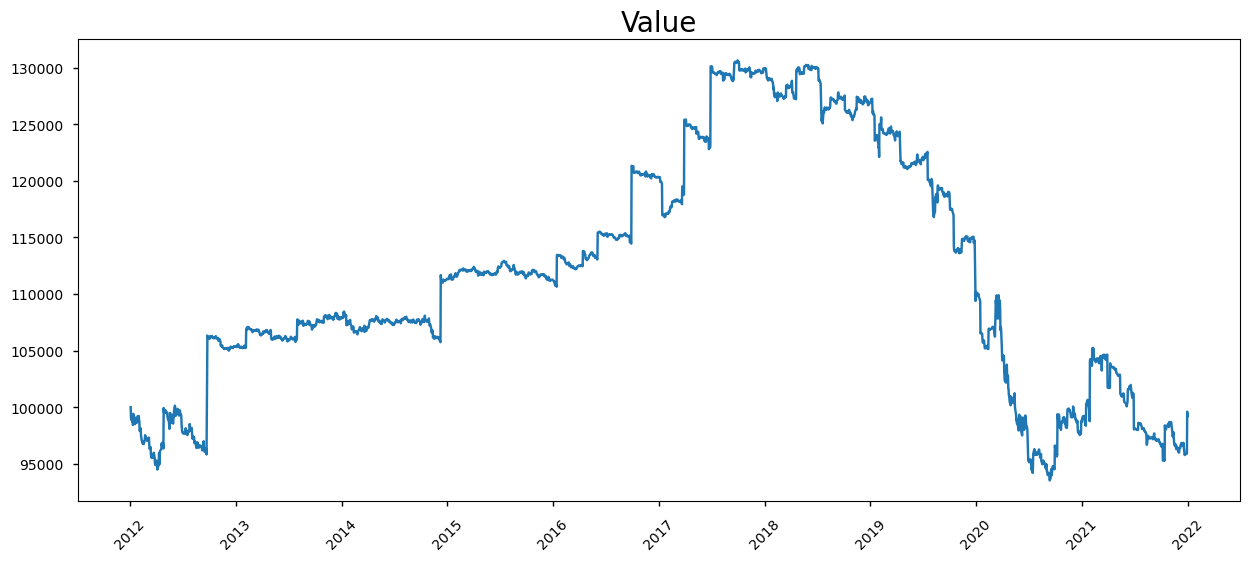

In [212]:
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(output_df['Date']),output_df['Ending_Total_Amt'])
plt.xticks(rotation=45)
plt.title('Value',fontsize = 20)
plt.show()

### 5.2 Backtesting

In [256]:
class strategy_Backtester():
    def __init__(self,start_date,end_date,**kwargs):
        self.stock_list = list(np.sort(np.unique(np.concatenate([final_pairs_df['Y'].values,
                                                    final_pairs_df['X'].values]))))
        
        self.start_date = start_date
        self.end_date = end_date
        self.prices_df = self.prices_download(start_date,end_date)
        self.benchmark_data = self.benchmark_data_download(start_date,end_date)
        self.strategy_out_df = self.get_strategy_output(self.prices_df,**kwargs)
        self.calc_metrics()
        
    def prices_download(self,start_date,end_date):
        return yf.download(self.stock_list,start=start_date,end=end_date,progress=False)
    
    def benchmark_data_download(self,start_date,end_date):
        return yf.download('^GSPC',start=start_date,end=end_date,progress=False)
    
    def get_strategy_output(self,prices_df,**kwargs):
        strategy = pairs_trading_strategy(prices_df,**kwargs)
        return strategy.out_df
    
    def calc_metrics(self):
        self.benchmark_returns = self.benchmark_data['Adj Close'].pct_change().fillna(0)
        self.benchmark_cum_returns = self.benchmark_data['Adj Close']/self.benchmark_data['Adj Close'].iloc[0]
        self.strategy_returns = self.strategy_out_df['Return']
        self.strategy_cum_returns = self.strategy_out_df['Ending_Total_Amt']/self.strategy_out_df['Ending_Total_Amt'].iloc[0]
        
        self.strategy_sharpe_ratio = self.calc_sharpe_ratio(self.strategy_returns)
        self.benchmark_sharpe_ratio = self.calc_sharpe_ratio(self.benchmark_returns)
        
        self.information_ratio = self.calc_information_ratio(self.strategy_returns,
                                                             self.benchmark_returns)
        
        self.strategy_max_drawdown = np.max(self.calc_drawdown(self.strategy_cum_returns))
        self.benchmark_max_drawdown = np.max(self.calc_drawdown(self.benchmark_cum_returns))
        
    def print_metrics(self):
        print('Backtest Results'.center(60))
        print('='*60)
        print('Start Date'.ljust(30,' '),':',self.start_date)
        print('End Date'.ljust(30,' '),':',self.end_date)
        print('='*60)
        
        print('Strategy Cum.returns (%)'.ljust(30,' '),':',f'{(self.strategy_cum_returns.iloc[-1]-1)*100:.2f}%'.rjust(6,' '))
        print('Benchmark Cum.Returns (%)'.ljust(30,' '),':',f'{(self.benchmark_cum_returns.iloc[-1]-1)*100:.2f}%'.rjust(6,' '))
        print('Sharpe Ratio - Strategy'.ljust(30,' '),':',f'{self.strategy_sharpe_ratio:.2f}'.rjust(6,' '))
        print('Sharpe Ratio - Benchmark'.ljust(30,' '),':',f'{self.benchmark_sharpe_ratio:.2f}'.rjust(6,' '))
        print('Information Ratio'.ljust(30,' '),':',f'{self.information_ratio:.2f}'.rjust(6,' '))
        print('Max Draw Down - Strategy (%)'.ljust(30,' '),':',f'{self.strategy_max_drawdown*100:.2f}%'.rjust(6,' '))
        print('Max Draw Down - Benchmark (%)'.ljust(30,' '),':',f'{self.benchmark_max_drawdown*100:.2f}%'.rjust(6,' '))
        print('='*60)
        
    def calc_sharpe_ratio(self,returns):
        mean_strategy_return = np.mean(returns)*252
        std_strategy_return = np.std(returns)*(252**0.5)
        sharpe_ratio = (mean_strategy_return-0.04)/std_strategy_return
        return sharpe_ratio
    
    def calc_information_ratio(self,return_1,return_2):
        diff = return_1.values - return_2.values
        alpha = np.mean(diff)*252
        tracking_error = np.std(diff)*(252**0.5)
        information_ratio = alpha/tracking_error
        return information_ratio
    
    def calc_drawdown(self,returns):
        max_idx = 0
        max_val = returns[0]
        drawdown = returns.copy()
        for bar,val in enumerate(returns):
            if val >= max_val:
                max_val = val
                max_idx = bar
            drawdown.iloc[bar] = max_val-val
        return drawdown    

In [255]:
bt = strategy_Backtester(start_date='2012-01-01',end_date='2022-01-01')

0.0 % Completed...
4.0 % Completed...
7.9 % Completed...
11.9 % Completed...
15.9 % Completed...
19.9 % Completed...
23.8 % Completed...
27.8 % Completed...
31.8 % Completed...
35.8 % Completed...
39.7 % Completed...
43.7 % Completed...
47.7 % Completed...
51.6 % Completed...
55.6 % Completed...
59.6 % Completed...
63.6 % Completed...
67.5 % Completed...
71.5 % Completed...
75.5 % Completed...
79.5 % Completed...
83.4 % Completed...
87.4 % Completed...
91.4 % Completed...
95.4 % Completed...
99.3 % Completed...


In [257]:
bt.print_metrics()

                      Backtest Results                      
Start Date                     : 2012-01-01
End Date                       : 2022-01-01
Strategy Cum.returns (%)       : 571.60%
Benchmark Cum.Returns (%)      : 273.22%
Sharpe Ratio - Strategy        :   0.78
Sharpe Ratio - Benchmark       :   0.64
Information Ratio              :   0.26
Max Draw Down - Strategy (%)   : 165.44%
Max Draw Down - Benchmark (%)  : 89.95%


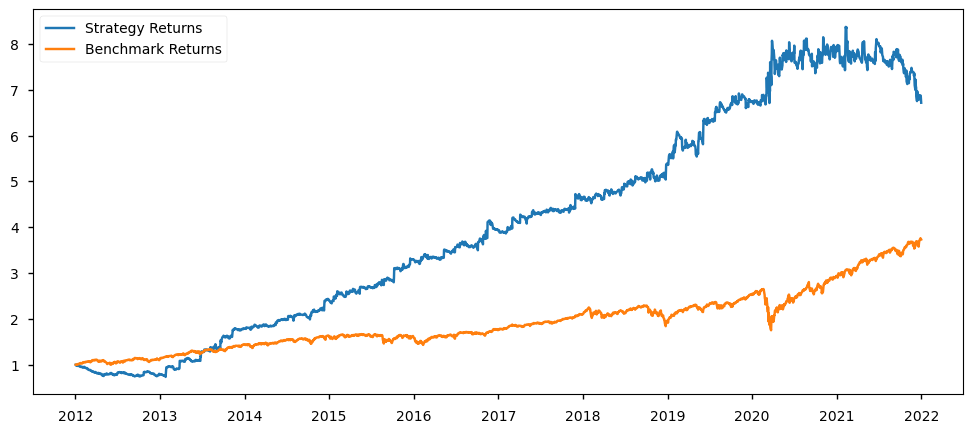

In [258]:
plt.figure(figsize=(12,5))
plt.plot(bt.prices_df.index,bt.strategy_cum_returns.values,label='Strategy Returns')
plt.plot(bt.benchmark_cum_returns,label='Benchmark Returns')
plt.legend()

### 5.3 Finding the optimal Thresholds

In [49]:
from itertools import product

In [51]:
#entry_thresholds = [1,1.25,1.5,2]
entry_thresholds = [0.5,0.75,1]
#exit_thresholds = [1.5,2,2.5,3]
exit_thresholds = [3,3.5,4]

In [53]:
date_ranges = pd.date_range('2012-01-01','2022-01-01',periods=11)

In [54]:
thresholds = product(entry_thresholds,exit_thresholds)

#threshold_cv_results = {'long_entry_threshold':[],
#                        'short_entry_threshold':[],
#                        'long_exit_threshold':[],
#                        'short_exit_threshold':[],
#                        'Mean_Sharpe_ratio':[],
 #                       'Std_Sharpe_ratio':[],
 #                       'Mean_Max_Drawdown':[],
 #                       'Std_Max_Drawdown':[]
 #                      }

count=0
for entry_threshold,exit_threshold in thresholds:
    if entry_threshold < exit_threshold:
        count += 1
        print(f'Combination {count}:',sep=' ')
        print([entry_threshold,exit_threshold])
        print('-'*50)
        long_entry_threshold,long_exit_threshold = entry_threshold,exit_threshold
        short_entry_threshold,short_exit_threshold = -entry_threshold,-exit_threshold
        sharpe_ratio_list =[]
        max_drawdown_list = []
        iteration = 0
        for i in range(len(date_ranges)-1):
            iteration += 1
            print(f'Iteration {iteration}:')
            start_date = date_ranges[i]
            end_date = date_ranges[i+1]
            bt = strategy_Backtester(start_date=start_date,end_date=end_date,
                                     long_entry_threshold=long_entry_threshold,
                                     long_exit_threshold=long_exit_threshold,
                                     short_entry_threshold=short_entry_threshold,
                                     short_exit_threshold=short_exit_threshold)
            bt.calc_metrics()
            sharpe_ratio_list.append(bt.strategy_sharpe_ratio)
            max_drawdown_list.append(bt.strategy_max_drawdown)
            print('-'*50)
        threshold_cv_results['long_entry_threshold'].append(long_entry_threshold)
        threshold_cv_results['short_entry_threshold'].append(short_entry_threshold)
        threshold_cv_results['long_exit_threshold'].append(long_exit_threshold)
        threshold_cv_results['short_exit_threshold'].append(short_exit_threshold)
        threshold_cv_results['Mean_Sharpe_ratio'].append(np.mean(sharpe_ratio_list))
        threshold_cv_results['Std_Sharpe_ratio'].append(np.std(sharpe_ratio_list))
        threshold_cv_results['Mean_Max_Drawdown'].append(np.mean(max_drawdown_list))
        threshold_cv_results['Std_Max_Drawdown'].append(np.std(max_drawdown_list))
        print(f'Mean_Sharpe:{np.mean(sharpe_ratio_list):.2f}')
        print(f'Std_Sharpe:{np.std(sharpe_ratio_list):.2f}')
        print(f'Mean_Drawdown:{np.mean(max_drawdown_list):.2f}')
        print(f'Std_Drawdown:{np.std(max_drawdown_list):.2f}')
       
    if count % 3==0:
        pd.DataFrame(threshold_cv_results).to_csv('Threshold_CV_results.csv')
        

Combination 1:
[1, 1.5]
--------------------------------------------------
Iteration 1:



1 Failed download:
['VRSK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2012-01-01 00:00:00 -> 2012-12-31 07:12:00)')


0.0 % Completed...
40.2 % Completed...
80.3 % Completed...
--------------------------------------------------
Iteration 2:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 3:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 4:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 5:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 6:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 7:



1 Failed download:
['PG']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2017-12-31 19:12:00 -> 2019-01-01 02:24:00)')


0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 8:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 9:



14 Failed downloads:
['PAYX', 'TTWO', 'PEG', 'ANSS', 'DG', 'CP', 'UNP', 'CTAS', 'TER', 'GIB', 'IP', 'UNH', 'RVTY', 'IHG']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 09:36:00 -> 2020-12-31 16:48:00)')


0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 10:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Combination 2:
[1, 2]
--------------------------------------------------
Iteration 1:
0.0 % Completed...
40.2 % Completed...
80.3 % Completed...
--------------------------------------------------
Iteration 2:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 3:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 4:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 5:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 6:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
------


2 Failed downloads:
['NTRS', 'EXPE']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-12-31 16:48:00 -> 2022-01-01 00:00:00)')


0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Combination 7:
[1.25, 2.5]
--------------------------------------------------
Iteration 1:
0.0 % Completed...
40.2 % Completed...
80.3 % Completed...
--------------------------------------------------
Iteration 2:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 3:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 4:



2 Failed downloads:
['OMC', 'C']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2014-12-31 21:36:00 -> 2016-01-01 04:48:00)')


0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 5:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 6:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 7:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 8:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 9:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 10:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Combination 8:
[1.25, 3]
--------------------------------------------------
Iteration 1:
0.0 % Completed...
40.2 % Completed...
80.3 % Completed...
---


1 Failed download:
['DIS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-12-31 16:48:00 -> 2022-01-01 00:00:00)')


0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Combination 10:
[1.5, 2.5]
--------------------------------------------------
Iteration 1:
0.0 % Completed...
40.2 % Completed...
80.3 % Completed...
--------------------------------------------------
Iteration 2:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 3:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 4:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 5:



1 Failed download:
['HST']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-01-01 04:48:00 -> 2016-12-31 12:00:00)')


0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 6:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 7:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 8:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 9:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 10:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Combination 11:
[1.5, 3]
--------------------------------------------------
Iteration 1:



1 Failed download:
['ROK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2012-01-01 00:00:00 -> 2012-12-31 07:12:00)')


0.0 % Completed...
40.2 % Completed...
80.3 % Completed...
--------------------------------------------------
Iteration 2:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 3:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 4:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 5:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 6:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 7:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 8:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 9:
0.0 % Completed.


1 Failed download:
['EFX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-12-31 12:00:00 -> 2017-12-31 19:12:00)')


0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 7:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 8:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 9:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 10:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Combination 13:
[2, 3]
--------------------------------------------------
Iteration 1:
0.0 % Completed...
40.2 % Completed...
80.3 % Completed...
--------------------------------------------------
Iteration 2:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 3:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
-----


1 Failed download:
['D']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-01-01 04:48:00 -> 2016-12-31 12:00:00)')


0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 6:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 7:
0.0 % Completed...
39.8 % Completed...
79.7 % Completed...
--------------------------------------------------
Iteration 8:
0.0 % Completed...
39.7 % Completed...
79.4 % Completed...
--------------------------------------------------
Iteration 9:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------
Iteration 10:
0.0 % Completed...
39.5 % Completed...
79.1 % Completed...
--------------------------------------------------


In [55]:
pd.DataFrame(threshold_cv_results)

,long_entry_threshold,short_entry_threshold,long_exit_threshold,short_exit_threshold,Mean_Sharpe_ratio,Std_Sharpe_ratio,Mean_Max_Drawdown,Std_Max_Drawdown
0,1.00,-1.00,1.5,-1.5,-0.528091,0.989817,0.254343,0.205052
1,1.00,-1.00,2.0,-2.0,0.042467,1.068887,0.172990,0.129222
2,1.00,-1.00,2.5,-2.5,0.783309,0.887707,0.115146,0.066935
3,1.00,-1.00,3.0,-3.0,0.914511,0.766423,0.108660,0.055864
4,1.25,-1.25,1.5,-1.5,-0.705492,1.185006,0.339096,0.233945
5,1.25,-1.25,2.0,-2.0,-0.148748,1.020056,0.222912,0.152580
6,1.25,-1.25,2.5,-2.5,0.357156,0.999448,0.155338,0.073251
7,1.25,-1.25,3.0,-3.0,0.837022,0.761128,0.123815,0.051193
8,1.50,-1.50,2.0,-2.0,0.067171,0.839636,0.191527,0.099512
9,1.50,-1.50,2.5,-2.5,0.132174,0.899211,0.164068,0.082158


### 5.4 Evaluating the strategy on test data

In [251]:
best_entry_threshold = 1
best_exit_threshold = 3

In [252]:
bt_test = strategy_Backtester(start_date='2022-01-01',end_date='2023-11-30',
                    long_entry_threshold = best_entry_threshold,
                   short_entry_threshold = -best_entry_threshold,
                   long_exit_threshold = best_exit_threshold,
                   short_exit_threshold = -best_exit_threshold)

0.0 % Completed...
20.8 % Completed...
41.7 % Completed...
62.5 % Completed...
83.3 % Completed...


In [253]:
bt_test.print_metrics()

                      Backtest Results                      
Start Date                     : 2022-01-01
End Date                       : 2023-11-30
Strategy Cum.returns (%)       : -28.02%
Benchmark Cum.Returns (%)      : -5.13%
Sharpe Ratio - Strategy        :  -1.10
Sharpe Ratio - Benchmark       :  -0.24
Information Ratio              :  -0.54
Max Draw Down - Strategy (%)   : 31.54%
Max Draw Down - Benchmark (%)  : 25.43%


<Axes: >

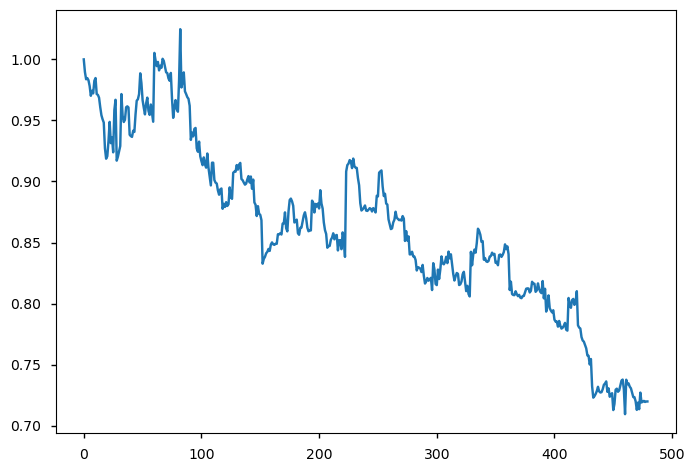

In [254]:
bt_test.strategy_cum_returns.plot()